# Описание

В условиях задачи нам даны описания к данным и указаны типы данных.

## Таблицы, поля и связи

### train

| Column                         | Ref                 | Type      | Notes                         | Description                                                                                                                                                                                                                                                                                                                                                                                               |
|--------------------------------|---------------------|-----------|-------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| row_id                         |                     | (int64)   |                               | ID code for the row                                                                                                                                                                                                                                                                                                                                                                                       |
| timestamp                      |                     | (int64)   |                               | time in ms between user interaction and the first event completion from that user                                                                                                                                                                                                                                                                                                                         |
| user_id                        |                     | (int32)   |                               | ID user-a. У нас нет отдельно таблицы с user.                                                                                                                                                                                                                                                                                                                                                             |
| **content_id**                 | lectures.lecture_id | (int16)   |                               | ID code for the user interaction. Used in **lectures.lecture_id**                                                                                                                                                                                                                                                                                                                                         |
| content_type_id                |                     | (int8)    |                               | 0 - question, 1 - lecture.                                                                                                                                                                                                                                                                                                                                                                                | 
| **task_container_id**          |                     | (int16)   | ID набора вопросов или лекций | Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.                                                                                                                                                                                                   |
| user_answer                    |                     | (int8)    | [ 3  2  0  1 -1]              | Read -1 as null, for lectures                                                                                                                                                                                                                                                                                                                                                                             |
| answered_correctly             |                     | (int8)    | [ 1  0 -1]                    | Read -1 as null, for lectures                                                                                                                                                                                                                                                                                                                                                                             |
| prior_question_elapsed_time    |                     | (float32) |                               | The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.                                                                                                       |
| prior_question_had_explanation |                     | (bool)    |                               | Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.  |

### questions 

Метаданные вопросов, заданных студентам (users)

| Column             | Ref               | Type | Notes | Description                                                                             |
|--------------------|-------------------|------|-------|-----------------------------------------------------------------------------------------|
| question_id        | train.content_id  |      |       | foreign key for the train/test content_id column, when the content type is question (0) |
| bundle_id          |                   |      |       | code for which questions are served together                                            |
| **correct_answer** | train.user_answer |      |       | Can be compared with the **train.user_answer** column to check if the user was right    |
| part               |                   |      |       | the relevant section of the TOEIC test                                                  |
| tags               | ???               |      |       | these codes are sufficient for clustering the questions together                        |

### lectures 

Лекции, просмотренные студентами (users)

| Column         | Ref              | Type | Notes | Description                                                                                                                                        |
|----------------|------------------|------|-------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **lecture_id** | train.content_id |      |       | foreign key for the **train.content_id** column, when the content type is lecture (1)                                                              |
| part           |                  |      |       | top level category code for the lecture                                                                                                            |
| tag            | ???              |      |       | one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.  |
| type_of        |                  |      |       | brief description                                                                                                                                  |


# Imports

In [94]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

# Files

In [7]:
! du -hs /code/mipt.py.project/data/lms/hw_03/*

12K	/code/mipt.py.project/data/lms/hw_03/lectures.csv
292K	/code/mipt.py.project/data/lms/hw_03/questions.csv
5,5G	/code/mipt.py.project/data/lms/hw_03/train.csv


In [15]:
! wc -l /code/mipt.py.project/data/lms/hw_03/*

       419 /code/mipt.py.project/data/lms/hw_03/lectures.csv
     13524 /code/mipt.py.project/data/lms/hw_03/questions.csv
 101230333 /code/mipt.py.project/data/lms/hw_03/train.csv
 101244276 total


Файл train.csv содержит 101M+ строк и его размер 5,5GB!

In [23]:
! find /code/mipt.py.project/data/lms/hw_03/ -type f | xargs head -2

==> /code/mipt.py.project/data/lms/hw_03/questions.csv <==
question_id,bundle_id,correct_answer,part,tags
0,0,0,1,51 131 162 38

==> /code/mipt.py.project/data/lms/hw_03/lectures.csv <==
lecture_id,tag,part,type_of
89,159,5,concept

==> /code/mipt.py.project/data/lms/hw_03/train.csv <==
row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,,


Во всех файлах delimeter: `,`

## Filenames

In [3]:
lectures_filename   = "/code/mipt.py.project/data/lms/hw_03/lectures.csv"
questions_filename  = "/code/mipt.py.project/data/lms/hw_03/questions.csv"
train_filename      = "/code/mipt.py.project/data/lms/hw_03/train.csv"
new_filename        = train_filename.replace('.csv', '.parquet')

# 1. Загрузка данных

## lectures.csv

In [37]:
lct_df = pd.read_csv(lectures_filename)
lct_df

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [25]:
lct_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


- 418 строк - соответствует `wc -l` минус заголовок
- Числовые типы определились корректно
- Категориальные типы: 
  - part
  - type_of


In [57]:
lct_df.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [39]:
print(lct_df['part'].unique())
print(lct_df['type_of'].unique())
print(lct_df['tag'].unique())

[5 1 6 2 7 3 4]
['concept' 'solving question' 'intention' 'starter']
[159  70  45  79 156 114 179 134  93  80  98 101  33  74  60 181  43   4
 109  89 142 140 104   1  65 155  26 178 173   7 147 171  78  62  64 141
 124 161  24  23 152   8  94 119  37 177  54 157 132   6  67 123  50  25
 175 116 136  20 129 127  53 130  13  42  72  36 172  57 151   9 187  58
 166  49 164 163  47 139  85  91 158  48  69  76  28 167  18   0  27  19
 149  99  39  34  61  14 113 182  55 145  96 133  12 106 126 105 125 168
   5  71  82  44 108 143  90  16 112  73  40 111  51  97  31  52 180 138
 150 120 128  68  95 170 184  30 174 153  66  17  75  83 183 148 144 103
 118  15 115 176 137 169   2]


- Можно преобразовать типы:
  - lecture_id: uint16
  - tag:        uint8
  - part:       uint8
  - type_of:    category

### lct_df = read_csv

Загрузка с оптимизированными типами данных

In [63]:
lct_dtypes = {
    'lecture_id': 'uint16',
    'tag':        'uint8',
    'part':       'uint8',
    'type_of':    'category',
}
lct_df = pd.read_csv(lectures_filename, dtype=lct_dtypes)
lct_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lecture_id  418 non-null    uint16  
 1   tag         418 non-null    uint8   
 2   part        418 non-null    uint8   
 3   type_of     418 non-null    category
dtypes: category(1), uint16(1), uint8(2)
memory usage: 2.4 KB


## questions.csv

In [8]:
qsn_df = pd.read_csv(questions_filename)
qsn_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [31]:
qsn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


- 13523 строк - соответствует `wc -l` минус заголовок

In [53]:
qsn_df.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [ ]:
qsn_df.isna().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

- Одно пустое значение в колонке tags

In [70]:
qsn_df[qsn_df['tags'].isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,<NA>


In [72]:
print(1 /13522 * 100)

0.007395355716609969


- Можно преобразовать типы:
  - question_id:    uint16
  - bundle_id:      uint16
  - correct_answer: uint8
  - part:           uint8
  - tags:           set 

### qsn_df = read_csv

Загрузка и оптимизация типов

In [195]:
qsn_dtypes = {
    'question_id':    'int16',
    'bundle_id':      'int16',
    'correct_answer': 'int8',
    'part':           'int8',
}
qsn_df = pd.read_csv(questions_filename, dtype=qsn_dtypes)

# Заменяем NaN на пустую строку
qsn_df['tags'].fillna('', inplace=True)
# Меняем тип на category. Проверка уникальности набора тегов ниже.
qsn_df['tags'] = qsn_df['tags'].astype('category')

print(qsn_df.info())
qsn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   question_id     13523 non-null  int16   
 1   bundle_id       13523 non-null  int16   
 2   correct_answer  13523 non-null  int8    
 3   part            13523 non-null  int8    
 4   tags            13523 non-null  category
dtypes: category(1), int16(2), int8(2)
memory usage: 149.9 KB
None


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [190]:

# Проверяем значение tags на уникальность. Попробуем отсортировать значения внутри

tags = qsn_df['tags'].unique()
print(len(tags))
print(tags)
print(type(tags[0]))

tags = np.array(
    [
        ' '.join(sorted(x.split(), key=int))
        for x in tags
    ]
)
print(tags)
print(len(np.unique(tags)))

1520
['38 51 131 162' '36 81 131' '92 101 131 162' ... '59 92 136' '59 81 106'
 '92 157 169']
<class 'str'>
['38 51 131 162' '36 81 131' '92 101 131 162' ... '59 92 136' '59 81 106'
 '92 157 169']
1520


- В колонке tags сами теги уже находятся определенном порядке, не требуется сортировка тегов внутри tags
- Преобразуем в тип category при загрузке

In [48]:
for col in (
    'bundle_id',
    'part',
    'correct_answer',
    'tags',
):
    print(f"{col}: {qsn_df[col].nunique()}")

print("\nparts (sections in test):", qsn_df['part'].unique())
print("correct_answer:", qsn_df['correct_answer'].unique())

bundle_id: 9765
part: 7
correct_answer: 4
tags: 1519

parts (sections in test): [1 2 3 4 5 6 7]
correct_answer: [0 1 3 2]


- В тесте 7 секций
- В вопросе 4 варианта ответа


In [52]:
qsn_df[qsn_df['tags'].isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


## train.cvs

- Как нам показали du и wc выше, здесь 101M+ строк и 5,5GB данных. 
- Поэтому сейчас прочитаем, например, 100К строк данных

In [31]:
# Типы для train даны нам в условии задачи
trn_dtypes = {
    "row_id"                         : "int64",
    "timestamp"                      : "int64",
    "user_id"                        : "int32",
    "content_id"                     : "int16",
    "content_type_id"                : "int8",
    "task_container_id"              : "int16",
    "user_answer"                    : "int8",
    "answered_correctly"             : "int8",
    "prior_question_elapsed_time"    : "float32",
    "prior_question_had_explanation" : "boolean",
}    

In [39]:
trn_df = pd.read_csv(train_filename, dtype=trn_dtypes ,nrows=100_000)
# trn_df.memory_usage().sum()
trn_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
99995,99995,153647401,2078569,4334,0,275,3,0,6000.0,True
99996,99996,153692472,2078569,6436,0,276,3,0,9000.0,True
99997,99997,153722998,2078569,6446,0,277,2,1,21000.0,True
99998,99998,153759775,2078569,3715,0,278,3,0,12000.0,True


train
- Отсортирован по user_id
- Полный train с помощью pd.read_csv на моем ПК так и не загрузился
  


In [46]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          100000 non-null  int64  
 1   timestamp                       100000 non-null  int64  
 2   user_id                         100000 non-null  int32  
 3   content_id                      100000 non-null  int16  
 4   content_type_id                 100000 non-null  int8   
 5   task_container_id               100000 non-null  int16  
 6   user_answer                     100000 non-null  int8   
 7   answered_correctly              100000 non-null  int8   
 8   prior_question_elapsed_time     97834 non-null   float32
 9   prior_question_had_explanation  99652 non-null   boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 3.1 MB


### Конвертация в parquet

- Перепишем train в другой формат для ускорения работы (уменьшения времени загрузки с диска).
- Пусть это будет parquet с компрессией zstd.
- Будем использовать dask для переконвертации
- И далее использовать pandas для загрузки из parquet и работы

In [147]:
ddf = dd.read_csv(
    train_filename, 
    dtype=trn_dtypes,
    engine='pyarrow',
    on_bad_lines='warn', 
    skip_blank_lines=False, 
    header=0,
)
new_filename = train_filename.replace('.csv', '.parquet')
ddf.to_parquet(new_filename, compression='zstd', overwrite=True)

In [148]:
!du -hs /code/mipt.py.project/data/lms/hw_03/train.parquet/

1001M	/code/mipt.py.project/data/lms/hw_03/train.parquet/


### trn_df = read_parquet

Загрузка из формата parquet

In [27]:
trn_df = pd.read_parquet(
    new_filename,
    engine='pyarrow',
)

15 сек - загрузка всего train

In [95]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101230332 entries, 0 to 1080610
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 3.9 GB


In [110]:
# csv wc -l:    101_244_276 
# dask          101_230_332
trn_df.shape

(101230332, 10)

- `101230332 записей в dask dataframe`
- `101244276 строк в выводе wc -l`

In [146]:
check_df = pd.read_csv(
    train_filename, 
    usecols=[0],
    on_bad_lines='warn',
)

check_df.shape

(101230332, 1)

In [157]:
df_count = 101230332
wc_count = 101244276
diff = wc_count - 1 - df_count
print(f"Row count difference: {diff}, and % of wc: {diff / (wc_count - 1) * 100} ")


Row count difference: 13943, and % of wc: 0.013771642890425163 


In [162]:
! cat /code/mipt.py.project/data/lms/hw_03/train.csv | grep -vE '^$' | wc -l

101230333


- `101230332 записей в dask dataframe`
- `101230333 строк в выводе wc -l без пустых строк`

Нам повезло, это не косячные данные, это всего лишь лишние переносы строк.

In [28]:
trn_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
__null_dask_index__,,,,,,,,,,
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
1080606,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
1080607,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
1080608,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True


Кол-во студентов: 393656

---
# 2. Анализ пропусков

lectures

In [61]:
lct_df.isna().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

- Нет пустых значений


questions - проанализировали в предыдущем разделе

train

In [113]:
df_sum = trn_df.isna().sum()

total = len(trn_df)
for k, v in df_sum.items():
    print(f"{k}: {v}, percent: {v / total * 100}")
    

row_id: 0, percent: 0.0
timestamp: 0, percent: 0.0
user_id: 0, percent: 0.0
content_id: 0, percent: 0.0
content_type_id: 0, percent: 0.0
task_container_id: 0, percent: 0.0
user_answer: 0, percent: 0.0
answered_correctly: 0, percent: 0.0
prior_question_elapsed_time: 2351538, percent: 2.3229579055415916
prior_question_had_explanation: 392506, percent: 0.38773556526516184


Пустые значения содержат колонки:
- prior_question_elapsed_time
- prior_question_had_explanation

Судя по условию там могут быть пустые значения

---
# 3. Распределение переменных

In [114]:
lct_df

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [206]:
lct_df.duplicated().sum()

np.int64(0)

In [132]:
# Топ 10 тем лекций
lct_df.groupby(['tag']).size().sort_values(ascending=False).head(10)

tag
136    7
134    6
27     6
74     6
113    6
62     6
116    6
161    6
70     5
173    5
dtype: int64

In [145]:
# Топ 10 категорий лекций
df = lct_df.groupby(['part']).size().sort_values(ascending=False).head(10)
print(df)


part
5    143
6     83
2     56
1     54
7     32
4     31
3     19
dtype: int64


In [ ]:
lct_df['type_of'].unique()

array(['concept', 'solving question', 'intention', 'starter'],
      dtype=object)

In [207]:
qsn_df.duplicated().sum()

np.int64(0)

In [210]:
print(qsn_df['question_id'].nunique())
print(qsn_df['bundle_id'].nunique())

13523
9765


Кол-во вопросов: 13523

In [146]:
# Топ 10 секций теста TOEIC
qsn_df.groupby(['part']).size().sort_values(ascending=False).head(10)


part
5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
dtype: int64

In [196]:
trn_df['user_id'].nunique()

393656

Кол-во студентов: 393656

In [13]:
lct_df

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [197]:
trn_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
__null_dask_index__,,,,,,,,,,
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
1080606,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
1080607,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
1080608,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True


In [205]:
columns = [
    'timestamp',
    'user_id',
    'content_id',
    'content_type_id',
    'task_container_id',
    'user_answer',
    'answered_correctly',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
]
# print(trn_df.iloc[0:10_000_000].duplicated(subset=columns).sum())
print(trn_df.duplicated(subset=columns).sum())

135


## Удаление дублей в train

135 - дублей
, небольшое кол-во. Удалим дубли, оставляя только последние

In [208]:
trn_df.drop_duplicates(subset=columns, keep='last', inplace=True)

In [214]:
print(trn_df['task_container_id'].nunique())

trn_df.groupby('content_type_id')['task_container_id'].nunique()

10000


content_type_id
0    10000
1     9369
Name: task_container_id, dtype: int64

- 10000 - всего разных типов наборов вопросов или лекций
- 10000 - типов наборов вопросов
-  9369 - типов лекций, видимо по каким-то наборам вопросов нет лекций

Распределение ответов: неверных, верных

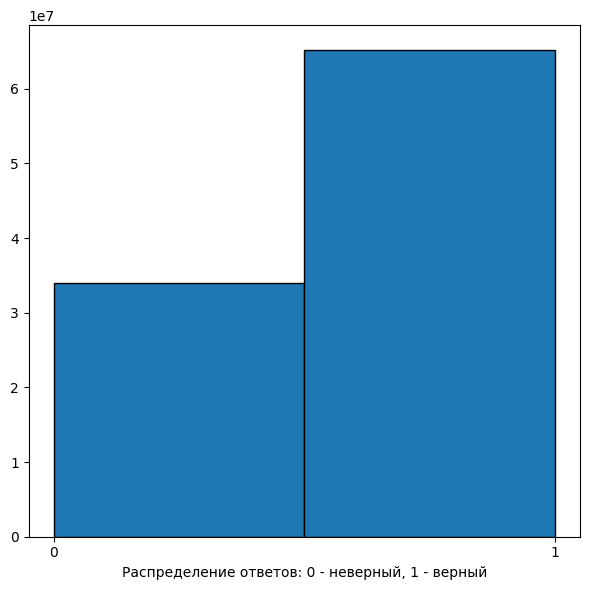

In [254]:
fig, (g1) = plt.subplots(1, 1, figsize=(6, 6))

# df = trn_df.iloc[0:1_000_000].query(
df = trn_df.query(
    'content_type_id == 0'
)['answered_correctly']

g1.hist(df, bins=2, edgecolor='black')
g1.set_xticks([0, 1])
g1.set_xlabel(
    "Распределение ответов: 0 - неверный, 1 - верный"
)

plt.tight_layout()
plt.show()

Распределение по времени от последнего взаимодействия до текущего момента (timestamp, дней)

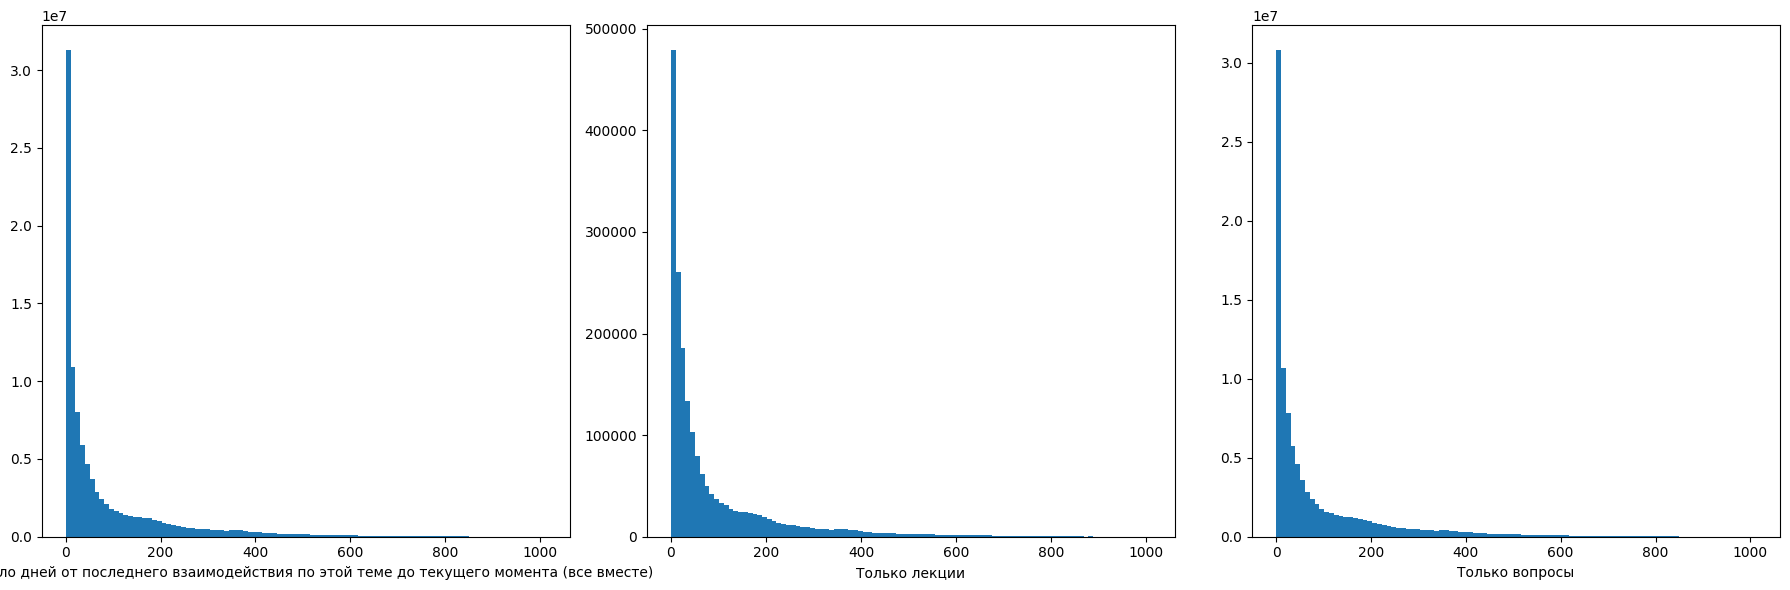

In [255]:
day_len = 1_000 * 60 * 60 * 24
#df = trn_df.iloc[0:1_000_000]
df = trn_df

fig, (g1, g2, g3) = plt.subplots(1, 3, figsize=(18, 6))

all = df['timestamp'] / day_len
g1.hist(all, bins=100)
g1.set_xlabel(
    "Прошло дней от последнего взаимодействия по этой теме"
    " до текущего момента (все вместе)"
)

lct_time = df[df['content_type_id'] == 1]['timestamp'] / day_len
g2.hist(lct_time, bins=100)
g2.set_xlabel("Только лекции")

qsn_time = df[df['content_type_id'] == 0]['timestamp'] / day_len
g3.hist(qsn_time, bins=100)
g3.set_xlabel("Только вопросы")

plt.tight_layout()
plt.show()

## Анализ выбросов timestamp

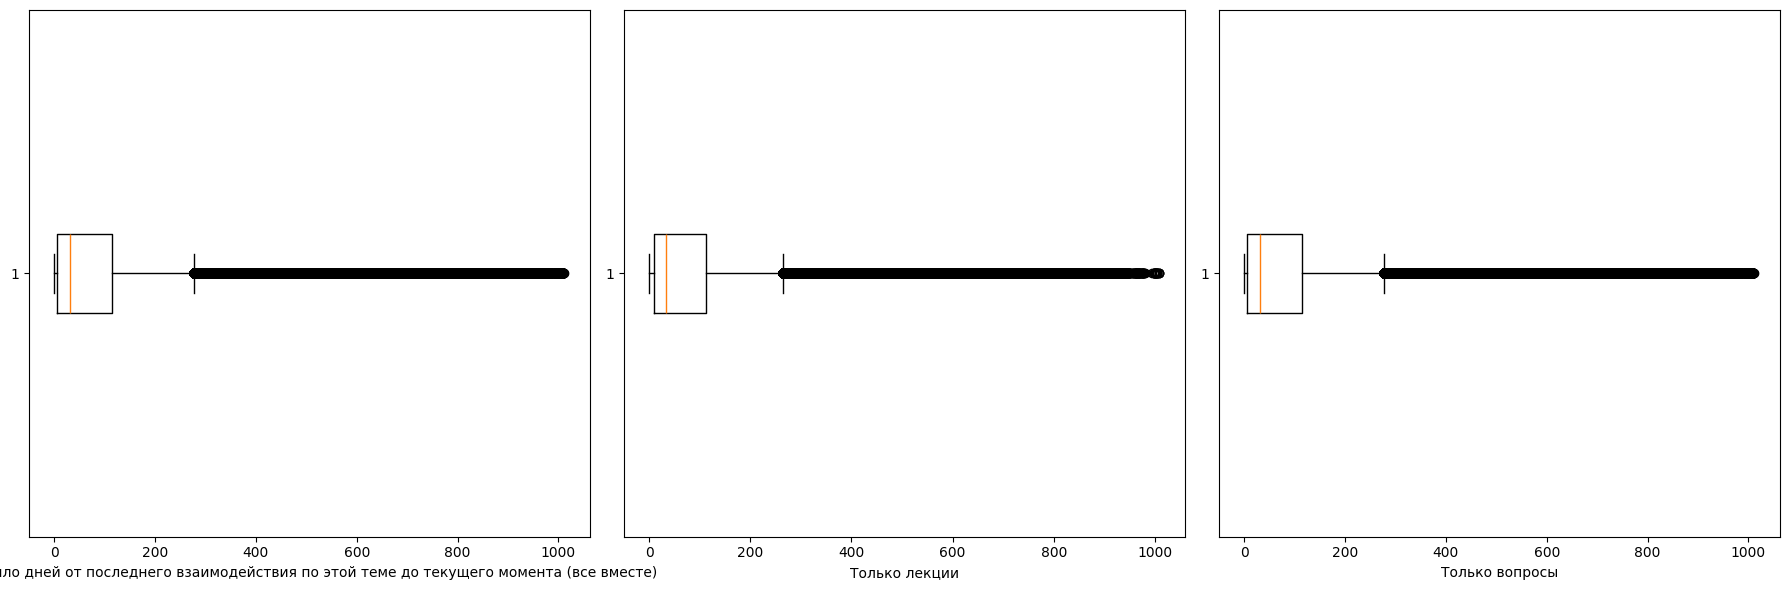

In [256]:
fig, (g1, g2, g3) = plt.subplots(1, 3, figsize=(18, 6))

g1.boxplot(all, vert=False)
g1.set_xlabel(
    "Прошло дней от последнего взаимодействия по этой теме"
    " до текущего момента (все вместе)"
)

g2.boxplot(lct_time, vert=False)
g2.set_xlabel("Только лекции")

g3.boxplot(qsn_time, vert=False)
g3.set_xlabel("Только вопросы")

plt.tight_layout()
plt.show()

In [240]:
trn_df['timestamp'].max() / day_len

np.float64(1011.8723616782407)

- В основном взаимодействие происходит в ближайшие дни, месяцы, но иногда и спустя 2 года.
- 1012 дней самый длительный интервал до взаимодействия

---
# 4. Анализ выбросов и аномалий

Частично в редыдущем пункте

---
# 5. Взаимосвязь между признаками

In [257]:
trn_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
__null_dask_index__,,,,,,,,,,
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
1080606,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
1080607,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
1080608,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True


### Правильность ответов от кол-ва посещенных лекций

In [308]:
#df = trn_df[0:10_000_000]  
df = trn_df

df = df[['user_id', 'content_type_id', 'answered_correctly']]
lection = 1
question = 0

# Расчитаем соотношение правильных к неправильным ответам для каждого студента
accuracy = df.query(
    f'content_type_id == {question}'
)[['user_id', 'answered_correctly']]

accuracy = accuracy.groupby(
    'user_id'
)['answered_correctly'].agg(
    ['mean']
).reset_index()

accuracy.rename(columns={'mean': 'accuracy'}, inplace=True)
print(accuracy)

# Подсчитаем кол-во посещенных лекций по каждому студенту
attendance = df.query(f'content_type_id == {lection}')[['user_id']]

attendance = attendance.groupby(
    'user_id'
)['user_id'].agg(
    ['count']
).reset_index()

attendance.rename(columns={'count': 'lectures'}, inplace=True)
print(attendance)

           user_id  accuracy
0              115  0.695652
1              124  0.233333
2             2746  0.578947
3             5382  0.672000
4             8623  0.642202
...            ...       ...
393651  2147470770  0.765487
393652  2147470777  0.691489
393653  2147481750  0.760000
393654  2147482216  0.643636
393655  2147482888  0.555556

[393656 rows x 2 columns]
           user_id  lectures
0             2746         1
1             5382         3
2             8623         3
3            12741         6
4            13134         7
...            ...       ...
149601  2147419988        44
149602  2147469944         3
149603  2147470770         2
149604  2147470777         6
149605  2147482216         5

[149606 rows x 2 columns]


In [310]:
# Соединяем две эти таблицы по user_id
accuracy_attendance = pd.merge(accuracy, attendance, on='user_id', how='inner')
accuracy_attendance

,user_id,accuracy,lectures
0,2746,0.578947,1
1,5382,0.672000,3
2,8623,0.642202,3
3,12741,0.573585,6
4,13134,0.706356,7
...,...,...,...
149601,2147419988,0.507671,44
149602,2147469944,0.732601,3
149603,2147470770,0.765487,2
149604,2147470777,0.691489,6


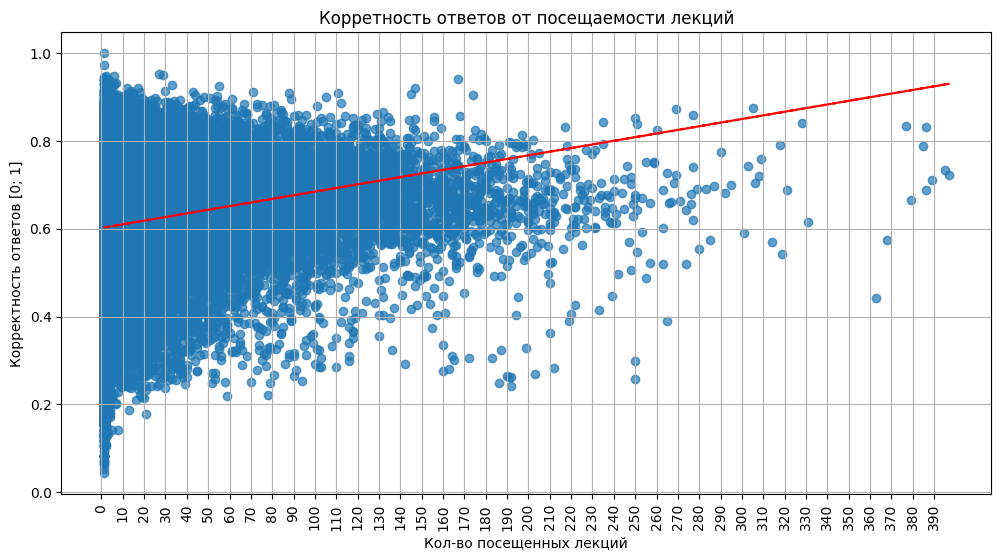

In [312]:
# Построим график распределения
fig = plt.figure(figsize=(12, 6))

x = accuracy_attendance['lectures']
y = accuracy_attendance['accuracy']

plt.scatter(x, y, alpha=0.7)
plt.title("Корретность ответов от посещаемости лекций")
plt.xticks(range(0, accuracy_attendance['lectures'].max() + 1, 10), rotation=90)
plt.xlabel("Кол-во посещенных лекций")
plt.ylabel("Корректность ответов [0; 1]")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.grid(True)

plt.show()

### Правильность ответов от количества вопросов

In [313]:
# Подсчитаем кол-во вопросов по каждому студенту
questions = df.query(f'content_type_id == {question}')[['user_id']]

questions = questions.groupby(
    'user_id'
)['user_id'].agg(
    ['count']
).reset_index()

questions.rename(columns={'count': 'questions'}, inplace=True)
print(questions)

           user_id  questions
0              115         46
1              124         30
2             2746         19
3             5382        125
4             8623        109
...            ...        ...
393651  2147470770        226
393652  2147470777        752
393653  2147481750         50
393654  2147482216        275
393655  2147482888         27

[393656 rows x 2 columns]


In [314]:
# Соединяем accuracy с questions по user_id
accuracy_questions = pd.merge(accuracy, questions, on='user_id', how='inner')
accuracy_questions

,user_id,accuracy,questions
0,115,0.695652,46
1,124,0.233333,30
2,2746,0.578947,19
3,5382,0.672000,125
4,8623,0.642202,109
...,...,...,...
393651,2147470770,0.765487,226
393652,2147470777,0.691489,752
393653,2147481750,0.760000,50
393654,2147482216,0.643636,275


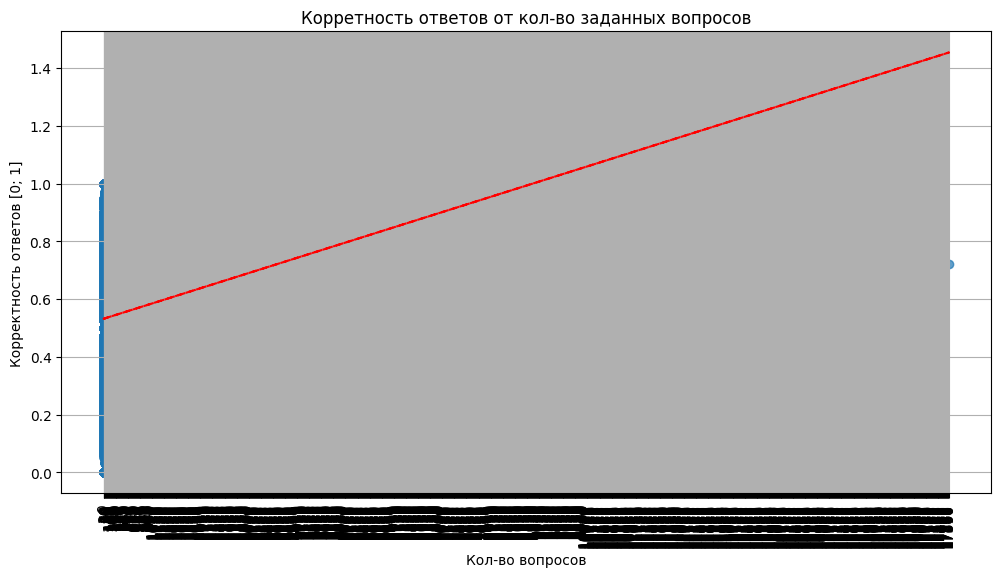

In [316]:
# Построим график распределения
fig = plt.figure(figsize=(12, 6))

x = accuracy_questions['questions']
y = accuracy_questions['accuracy']

plt.scatter(x, y, alpha=0.7)
plt.title("Корретность ответов от кол-во заданных вопросов")
plt.xticks(range(0, accuracy_questions['questions'].max() + 1, 10), rotation=90)
plt.xlabel("Кол-во вопросов")
plt.ylabel("Корректность ответов [0; 1]")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.grid(True)

plt.show()

Кому-то задали большое кол-во вопросов

In [323]:
accuracy_questions.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95])

,user_id,accuracy,questions
count,3.936560e+05,393656.000000,393656.000000
mean,1.076358e+09,0.545183,252.177447
std,6.201319e+08,0.163378,734.720053
min,1.150000e+02,0.000000,1.000000
25%,5.387596e+08,0.433333,30.000000
50%,1.077717e+09,0.571429,40.000000
75%,1.613533e+09,0.666667,154.000000
90%,1.933655e+09,0.736280,576.000000
95%,2.041013e+09,0.774194,1146.000000
max,2.147483e+09,1.000000,17609.000000


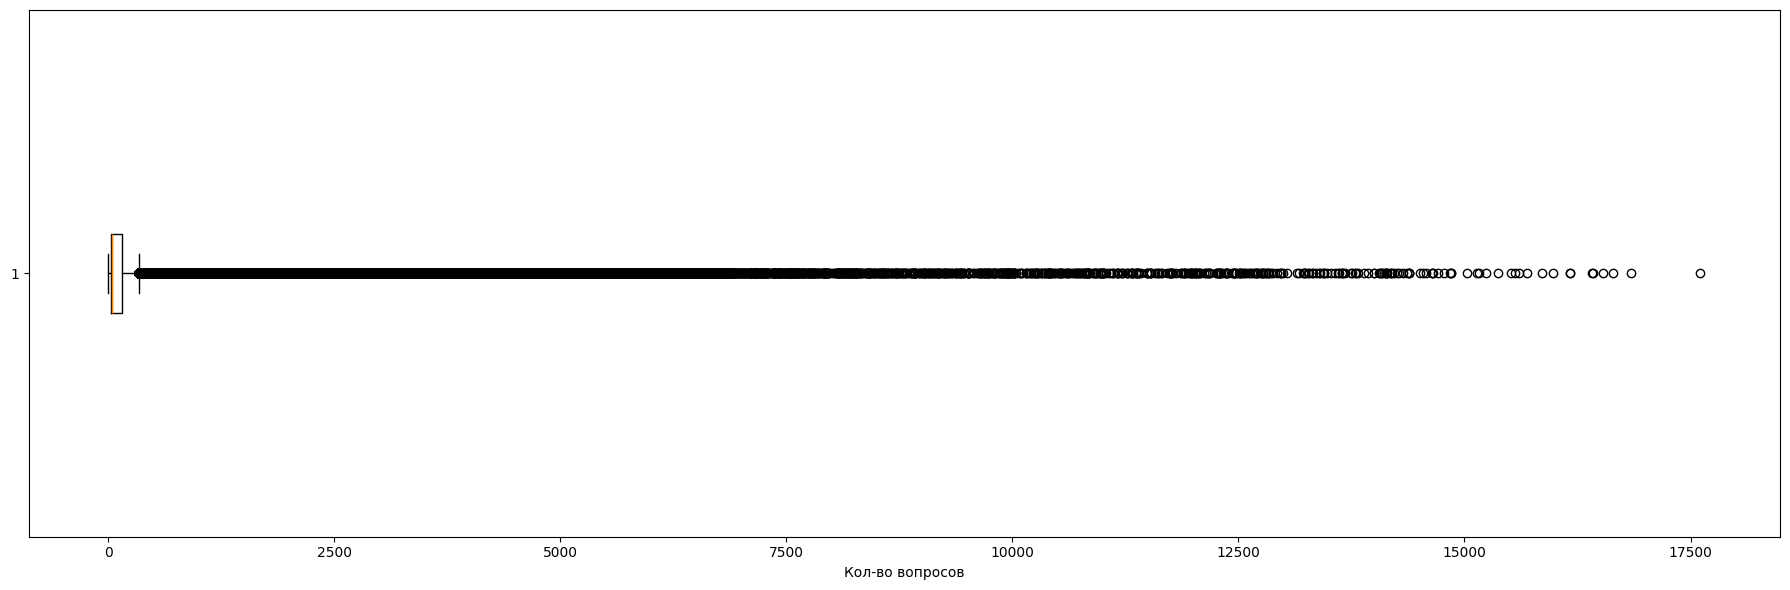

In [324]:
fig, (g1) = plt.subplots(1, 1, figsize=(18, 6))

g1.boxplot(accuracy_questions['questions'], vert=False)
g1.set_xlabel("Кол-во вопросов")

plt.tight_layout()
plt.show()

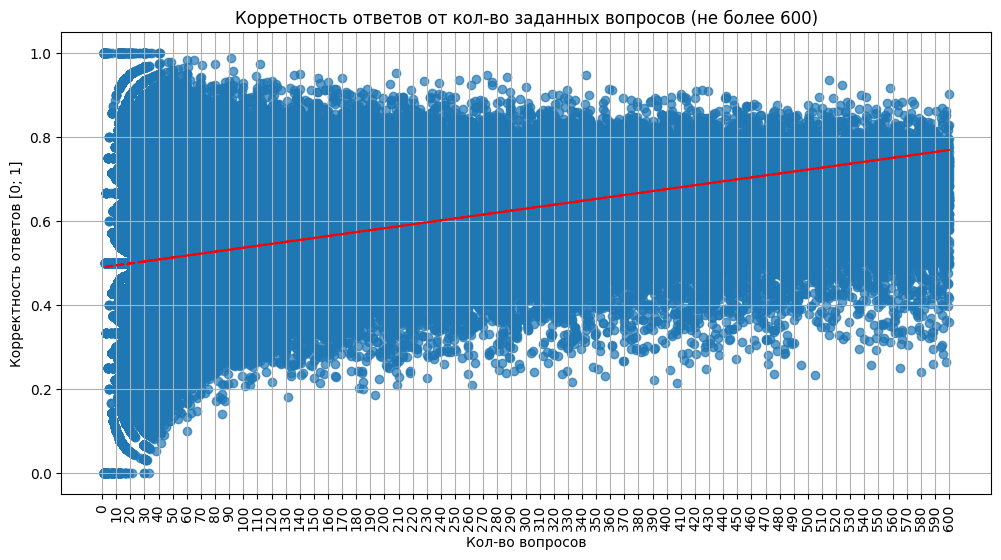

In [326]:
# Построим график. Учтем только кол-во вопросов до 600 включительно
fig = plt.figure(figsize=(12, 6))

limit = 600
plot_df = accuracy_questions[accuracy_questions['questions'] <= limit]
x = plot_df['questions']
y = plot_df['accuracy']

plt.scatter(x, y, alpha=0.7)
plt.title("Корретность ответов от кол-во заданных вопросов (не более 600)")
plt.xticks(range(0, plot_df['questions'].max() + 1, 10), rotation=90)
plt.xlabel("Кол-во вопросов")
plt.ylabel("Корректность ответов [0; 1]")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.grid(True)

plt.show()

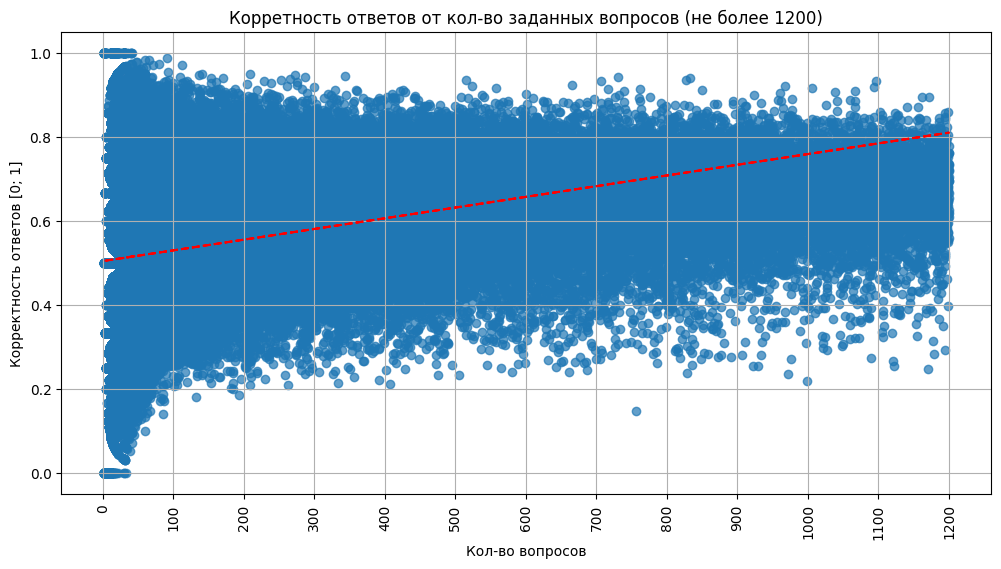

In [329]:
# Построим график. Учтем только кол-во вопросов до 1200 включительно
fig = plt.figure(figsize=(12, 6))

limit = 1200
plot_df = accuracy_questions[accuracy_questions['questions'] <= limit]
x = plot_df['questions']
y = plot_df['accuracy']

plt.scatter(x, y, alpha=0.7)
plt.title("Корретность ответов от кол-во заданных вопросов (не более 1200)")
plt.xticks(range(0, plot_df['questions'].max() + 1, 100), rotation=90)
plt.xlabel("Кол-во вопросов")
plt.ylabel("Корректность ответов [0; 1]")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.grid(True)

plt.show()